**Sudeshna Bora**

**AAND Numerical Assignment 04**

In [1]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math

**1**

In [2]:
h1_data = sio.loadmat("c1p8.mat")
spikes = h1_data['rho']
stimulus = h1_data['stim'].T
stim = h1_data['stim'].flatten()

Given,

500 spikes in 1000 ms. 

Hence, 1 spike per ms . 

$\Delta t = 2$ 

Now,

20 minutes or 1200 seconds is the total duration. Additonally with 2ms resolution. So total length will be 

$\frac{20*60*1000}{2} = 600000$

We can also visualise it as 1 index represents a time of 2 ms.

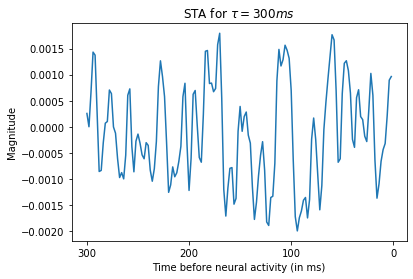

In [3]:
tau = 300
num_timesteps = int(tau/2) #adjusting resolution
sta_matrix02 = np.zeros((num_timesteps,1))

spike_times = spikes[num_timesteps:].nonzero()[0] + num_timesteps
num_spikes = len(spike_times)

for col in range(1):
    spike_times = spikes[num_timesteps:].nonzero()[0] + num_timesteps
    num_spikes = len(spike_times)
    for spikeIdx in spike_times:
        sta_matrix02[:,col] += stimulus[0,spikeIdx-num_timesteps:spikeIdx]
        sta_matrix02[:,col] /= num_spikes
        
sta02 = np.mean(sta_matrix02,axis=1)

fig, ax1 = plt.subplots(1)
ax1.plot(sta02)
ax1.set_xticks([0,50,100,150])
ax1.set_xticklabels(['300','200','100','0'])
ax1.set_xlabel('Time before neural activity (in ms)')
ax1.set_title(r'STA for $\tau = 300 ms$')
ax1.set_ylabel('Magnitude')
plt.show()

**2**

We will use $\frac{spikeCount}{Trial length}$ for mean firing rate

In [4]:
T = 20*60*1000
dt = 2
mean_firing_rate = spikes.sum() / T
stimulus_variance = stimulus.var() * dt
D = mean_firing_rate * sta02 / stimulus_variance
print(mean_firing_rate)

0.0446675


**3**

In [11]:
r_est = np.convolve(D, stim, mode='same')
r_est -= r_est.mean()
r_est += mean_firing_rate
print(np.mean(r_est))

0.04466750000000001


In [6]:
def sliding_window_function(tau, delta): return 1 / \
    delta if tau >= -delta/2 and tau < delta/2 else 0

In [7]:
t = np.linspace(-100, 100, 100)
swf = np.array([sliding_window_function(i, 20) for i in t])
r = np.convolve(np.roll(h1_data['rho'].flatten(), -50), swf)

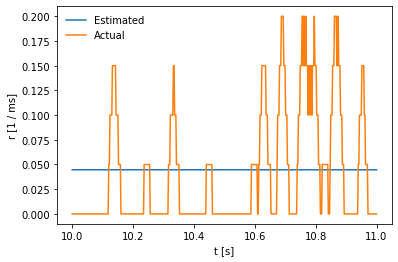

In [8]:
plt.plot(np.linspace(10, 11, 500), r_est[5000:5500], label='Estimated')
plt.plot(np.linspace(10, 11, 500), r[5000:5500], label='Actual')
plt.xlabel('t [s]')
plt.ylabel('r [1 / ms]')
plt.legend(frameon=False)